# Network Analysis
This file plots the feeders and finds the furthest loads from the transformers

In [1]:
!pip install networkx
!pip install xlrd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import numpy as np
import seaborn as sns
sns.set_style('whitegrid')


In [2]:
def construct_network(feeder_data):
    # Create a directed graph using NetworkX
    G = nx.Graph()

    # Add edges to the graph based on the feeder data
    for col, row in feeder_data.iterrows():
        source_node = row['NodeA']
        end_node = row['NodeB']
        distance = row['D[m]']
        phases = row['Phase']
        load = row['Load']

        G.add_edge(source_node, end_node, distance=distance, phases=phases, load=load)

    return G

def plot_network(network, feeder_data, ax):
    # Get X and Y coordinates for each node
    node_positions = {row['Node']: (row['X'], row['Y']) for _, row in xy_position.iterrows()}

    # Create a colormap based on the number of phases
    edge_colors = ['blue', 'green', 'red', 'black'] 

    # Map edge colors based on the phases
    edge_color_mapping = {i: edge_colors[i - 1] for i in range(1,5)}

    # Extract phase information for each edge
    edge_phases = [network.edges[edge]['phases'] for edge in network.edges]
    ## accounting for load 1 not having an entry
    node_colors = ["skyblue"] + ['orange' if feeder_data.loc[node]['Load'] == 1 else 'none' for node in range(len(feeder_data))]
    node_size = [5] + [1]*len(feeder_data)


    # Plot the network using matplotlib with specified node and edge colors
    nx.draw(network, ax = ax, pos=node_positions, with_labels=False, node_size=node_size, node_color=node_colors, font_size=8, edge_color=[edge_color_mapping[phase] for phase in edge_phases], width = 0.5)
    
    # Label nodes where loads are at NodeB
    labeled_nodes = set()
    overlapping_nodes = set()
    seen_coordinates = set()

    for node, (x, y) in node_positions.items():
        load_data = feeder_data[feeder_data['NodeB'] == node]['Load']
        if not load_data.empty and load_data.values[0] == 1:
            labeled_nodes.add(node)
            #plt.text(x, y, f"{node:.0f}", fontsize=8, ha='right', va='bottom')
            if (x, y) in seen_coordinates:
                overlapping_nodes.add(node)
            else:
                seen_coordinates.add((x, y))
    
    # Print the number of labeled nodes
    num_labeled_nodes = len(labeled_nodes)
    if num_labeled_nodes > 0:
        print(f"There are {num_labeled_nodes} labeled nodes with Load=1.")
        print(f"Labeled nodes: {labeled_nodes}")

        # Print the number of overlapping labeled nodes
        num_overlapping_nodes = len(overlapping_nodes)
        if num_overlapping_nodes > 0:
            print(f"{num_overlapping_nodes} of them are overlapping.")
            print(f"Overlapping nodes: {overlapping_nodes}")
        else:
            print("There are no overlapping labeled nodes.")
    else:
        print("There are no labeled nodes with Load=1.")
    # Create a custom legend
    legend_patches = [mpatches.Patch(color=edge_colors[i], label=f'Phase {i+1}') for i in range(3)] + [mpatches.Patch(color=edge_colors[3], label=f'3 Phase')]
    leg = ax.legend(handles=legend_patches, title='Phases', fontsize = 8)
    leg.get_title().set_fontsize('8')

In [3]:
def OpenFile(Net,Feed):
    try:
        with open(f"NandoLV/LVNetworkModels/Network_{Net}/Feeder_{Feed}/Feeder_Data.xls", 'rb') as f:
            feeder_data = pd.read_excel(f)
        with open(f"NandoLV/LVNetworkModels/Network_{Net}/Feeder_{Feed}/XY_Position.xls", 'rb') as f:
            xy_position = pd.read_excel(f)
        return True, feeder_data, xy_position
    except:
        return False, 0, 0

In [4]:
def count_overlapping_nodes(feeder_data, xy_position):
    # Label nodes where loads are at NodeB
    labeled_nodes = set()
    overlapping_nodes = set()
    seen_coordinates = set()
    
    node_positions = {row['Node']: (row['X'], row['Y']) for _, row in xy_position.iterrows()}

    for node, (x, y) in node_positions.items():
        load_data = feeder_data[feeder_data['NodeB'] == node]['Load']
        if not load_data.empty and load_data.values[0] == 1:
            labeled_nodes.add(node)
            if (x, y) in seen_coordinates:
                overlapping_nodes.add(node)
            else:
                seen_coordinates.add((x, y))

    # Print the number of labeled nodes
    num_labeled_nodes = len(labeled_nodes)
    if num_labeled_nodes > 0:
        print(f"There are {num_labeled_nodes} labeled nodes with Load=1.")
        #print(f"Labeled nodes: {labeled_nodes}")

        # Print the number of overlapping labeled nodes
        num_overlapping_nodes = len(overlapping_nodes)
        if num_overlapping_nodes > 0:
            print(f"{num_overlapping_nodes} of them are overlapping.")
            #print(f"Overlapping nodes: {overlapping_nodes}")
        else:
            print("There are no overlapping labeled nodes.")
    else:
        print("There are no labeled nodes with Load=1.")
    return num_labeled_nodes, num_overlapping_nodes


In [5]:

distances = []
nodes = []
feed_info = {}
number_cust = []
for i in range(1,27):
    feed = 0
    while True:
        feed +=1
        exception, feeder_data, xy_position = OpenFile(i, feed)
        if not exception:
            break
        network = construct_network(feeder_data)
        node_positions = {node: (row['X'], row['Y']) for node, row in xy_position.iterrows()}
        
        shortest_distances = {}
        Load_Number = 1
        # NODE B HAS LOAD
        for load_node in feeder_data[feeder_data['Load'] == 1]['NodeB']:
            shortest_distances[Load_Number] = nx.shortest_path_length(network, source=load_node, target=1, weight="distance")
            Load_Number +=1
        

        
        
        #print(f"Network {i}, Feeder {feed}")
        number_cust.append(Load_Number)
        #feed_info[f"{i}, {feed}"] = count_overlapping_nodes(feeder_data, xy_position)
        
         
        max_pair = max(shortest_distances.items(), key=lambda x: x[1])
        #print(f"node {max_pair[0]} has length {max_pair[1]}m")
        distances.append(max_pair[1])
        #nodes.append(max_pair[0])



print("Number Customers:", max(number_cust), min(number_cust))
print("Max Line Lengths:", max(distances),min(distances))

Number Customers: 303 3
Max Line Lengths: 769.5020351532431 42.82540249283682


In [ ]:
"""
Load_Number = 1
shortest_distances = {}
for load_node in feeder_data[feeder_data['Load'] == 1]['NodeB']:
    shortest_distances[Load_Number] = nx.shortest_path_length(network, source=load_node, target=1, weight="distance")
    Load_Number +=1
print("the nodes in order of distance are; ", np.array(sorted(shortest_distances.items(), key=lambda x: x[1]))[:,0])
#print(f"furtest node from transformer has distance {max(shortest_distances)}")
max_pair = max(shortest_distances.items(), key=lambda x: x[1])
print(f"node {max_pair[0]} has length {max_pair[1]}m")
"""

There are 55 labeled nodes with Load=1.
Labeled nodes: {896.0, 898.0, 387.0, 388.0, 899.0, 900.0, 264.0, 522.0, 778.0, 780.0, 906.0, 785.0, 276.0, 406.0, 539.0, 289.0, 34.0, 676.0, 682.0, 556.0, 813.0, 47.0, 688.0, 817.0, 178.0, 562.0, 563.0, 314.0, 701.0, 702.0, 320.0, 835.0, 70.0, 327.0, 73.0, 74.0, 458.0, 208.0, 337.0, 83.0, 342.0, 860.0, 349.0, 861.0, 225.0, 611.0, 614.0, 619.0, 755.0, 629.0, 502.0, 886.0, 248.0, 249.0, 639.0}
2 of them are overlapping.
Overlapping nodes: {249.0, 74.0}
There are 175 labeled nodes with Load=1.
Labeled nodes: {1024.0, 514.0, 515.0, 2051.0, 520.0, 1545.0, 1546.0, 526.0, 527.0, 1559.0, 2075.0, 541.0, 1054.0, 545.0, 2085.0, 550.0, 1070.0, 2096.0, 2099.0, 2100.0, 569.0, 1594.0, 1596.0, 573.0, 1598.0, 67.0, 589.0, 2125.0, 591.0, 595.0, 1629.0, 1630.0, 1120.0, 613.0, 614.0, 616.0, 619.0, 2164.0, 1655.0, 1659.0, 637.0, 639.0, 641.0, 642.0, 1154.0, 2177.0, 2184.0, 1164.0, 1166.0, 1171.0, 2195.0, 151.0, 2199.0, 666.0, 667.0, 1691.0, 1190.0, 2220.0, 689.0, 177

Text(0.5, 1.0, 'Network 2 Feeder 1')

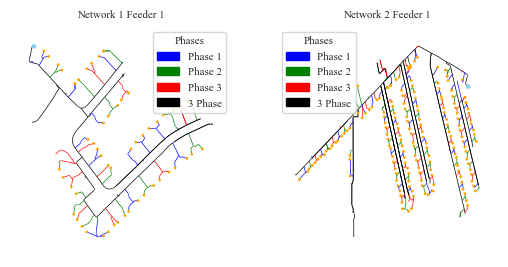

In [8]:
fig, ax = plt.subplots(1,2, figsize = (6.3, 3))

_, feeder_data, xy_position =OpenFile(1,1)
network = construct_network(feeder_data)
plot_network(network, feeder_data, ax[0])

_, feeder_data, xy_position =OpenFile(2,1)
network = construct_network(feeder_data)
plot_network(network, feeder_data, ax[1])
plt.rcParams['font.family'] = 'Times New Roman'


ax[0].set_title("Network 1 Feeder 1", fontsize = 8)
ax[1].set_title("Network 2 Feeder 1", fontsize = 8)


In [9]:
distances

[293.7458579295033,
 273.2239591311875,
 303.2998397951172,
 650.9812418931792,
 492.278189597738,
 654.6211586231033,
 720.6292603822284,
 630.5349230924996,
 370.75641563655194,
 431.07011072590575,
 413.6686371637536,
 640.0095525219161,
 413.4794628851769,
 374.0004037717868,
 272.24854799604606,
 180.73224960720546,
 403.7063518542329,
 327.4163659366517,
 437.06367634742475,
 279.44217498351105,
 417.1882298184566,
 93.69230471667943,
 217.44974609388433,
 429.392601237861,
 367.0596408513076,
 354.75301611534667,
 234.6620191719559,
 218.9321150280719,
 201.9647327316034,
 269.9363367393588,
 156.71534350403027,
 464.64546664518224,
 320.28261301708454,
 254.57212387843063,
 465.28975141150465,
 250.00208947479388,
 133.25142462258415,
 239.1051261308375,
 439.5946070034917,
 769.5020351532431,
 333.4178358743352,
 48.84700019822817,
 51.11276048736285,
 58.14265722728385,
 424.30543294605104,
 57.40193228881275,
 122.64176923490645,
 212.79060680397876,
 391.4542042933425,
 251

In [10]:
len(nodes)

0

In [11]:
print(nodes)

[]
